<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Irina Knyazeva, ODS Slack nickname : iknyazeva
    
## <center> Tutorial
### <center> "HANDLE DIFFERENT DATASET WITH DASK AND TRYING A LITTLE DASK ML"

## WHY DO I NEED DASK?

Dask provides high-level Array, Bag, and DataFrame collections that mimic NumPy, lists, and Pandas but can operate in parallel on datasets that don’t fit into main memory. Dask’s high-level collections are alternatives to NumPy and Pandas for large datasets.

## YOU DEFINITELY NEED DASK  IF
if problem size close to limits of RAM, but fits to disk


## Reading list
This notebook based mainly  based on this three sources

- [One more tutorial from analytics vidhya](https://www.analyticsvidhya.com/blog/2018/08/dask-big-datasets-machine_learning-python/)
- [taken from towardsdatascience](https://towardsdatascience.com/trying-out-dask-dataframes-in-python-for-fast-data-analysis-in-parallel-aa960c18a915)

- [DataCamp course](https://campus.datacamp.com/courses/parallel-computing-with-dask/)

- [Dask documentation](https://docs.dask.org/en/latest/) 




In [1]:
import psutil, os
import numpy as np
import pandas as pd
from dask import delayed
import gc
import time
import warnings
warnings.filterwarnings("ignore")

Let's  write a little function for tracking memory that takes python process

In [2]:
def memory_footprint():
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

In [3]:
before = memory_footprint()
print(f'Memory used before is {round(before,2)} MB')

Memory used before is 77.39 MB


In [4]:
N = (1024 ** 2) // 8
x = np.random.randn(50*N)
after = memory_footprint()
print(f'Memory used after is {round(after,2)} MB')

Memory used after is 127.43 MB


Computes, but doesn't bind result to a variable allocate extra memory

In [5]:
x ** 2
after1 = memory_footprint()
print(f' Extra memory obtained after computation {round(after1,2)} MB')

 Extra memory obtained after computation 177.43 MB


## Dask arrays

Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.[dask array documentation](http://docs.dask.org/en/latest/array.html)



<center>
<img src="http://docs.dask.org/en/latest/_images/dask-array-black-text.svg" />
In dask there is three main structures: dask array (based on numpy array), dask dataframe (based on pandas dataframe)  and dask bags (for unstructured data as text).

In [6]:
import dask.array as da
y = da.from_array(x, chunks=len(x)//4)
print('Dask arrays require little memory:', memory_footprint()-after1)

Dask arrays require little memory: 2.984375


In [7]:
import time
t_start = time.time()
x.mean()
t_end = time.time()
print('Compute mean value of this numpy array \n')
print('Elapsed time for compute mean of numpy array (ms):', round((t_end - t_start) * 1000))

Compute mean value of this numpy array 

Elapsed time for compute mean of numpy array (ms): 4


In [8]:
t_start = time.time()
y.mean().compute()
t_end = time.time()
print('Compute the same with dask \n')
print('Elapsed time for compute mean of dask array (ms):', round((t_end - t_start) * 1000))

Compute the same with dask 

Elapsed time for compute mean of dask array (ms): 21


Actually, this example will never be used in practice, because if your numpy already in memory, any partitioning will always raise computational time. But if you need to process data from HDF5, NetCDF or bulk of numpy files from disk it could be extremely useful

## Delayed operations with dask

But dask could be useful for small data with delayed computation. It could easily parallelize computation. Let's see the example with our previous numpy array   

In [69]:
def f(z):
    return np.sqrt(z + 4)
def g(y):
    return y - 3
def h(x):
    return x ** 2

time_start = time.time()
x = np.random.randn(50*N)
y=h(x);z=g(x); w=f(z+y);
time_end = time.time()
print('Elapsed time for compute complex functions with numpy array (ms):', round((time_end - time_start) * 1000))

Elapsed time for compute complex functions with numpy array (ms): 426


In [10]:
y = delayed(h)(x)
z = delayed(g)(x)
w = delayed(f)(z+y)
print('After we get dask delayed object', w)
time_start = time.time()
w.compute()
time_end = time.time()
print('Elapsed time for compute complex functions with numpy array with dask delayed (ms):', round((time_end - time_start) * 1000))

After we get dask delayed object Delayed('f-10fe1849-e5f7-4f12-97df-e728a4123d43')
Elapsed time for compute complex functions with numpy array with dask delayed (ms): 98


It is easily understood why computation time decreased with the computational graph. Let's do this with the second way of introducing delay functions

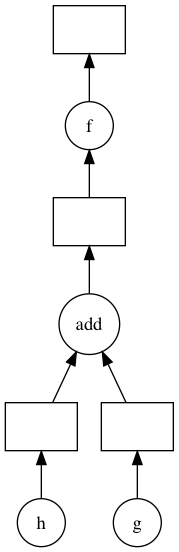

In [11]:
@delayed
def f(z):
    return np.sqrt(z + 4)
@delayed
def g(y):
    return y - 3
@delayed
def h(x):
    return x ** 2

y = h(x); z = g(x)
w = f(z+y)
w.visualize()

## Dask dataframe 

Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.
(See documentation)[http://docs.dask.org/en/latest/dataframe.html]

<center>
<img src="http://docs.dask.org/en/latest/_images/dask-dataframe.svg" width="40%" height="40% />


In [12]:
import dask.dataframe as dd

In [13]:
print('Let\'s return to start of our ML journey\n')
print('Load olympic dataset \n')
PATH = '../../data/athlete_events.csv'

Let's return to start of our ML journey

Load olympic dataset 



In [14]:
df = pd.read_csv(PATH)
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [15]:
m1=memory_footprint()
dask_df = dd.read_csv(PATH)
m2 = memory_footprint()
print('Dask do not allocate memory after creation:', m2-m1)

Dask do not allocate memory after creation: -5.16015625


In [16]:
print('But we could see data as in pandas dataframe:')
dask_df.head()

But we could see data as in pandas dataframe:


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [17]:
# building delayed  computation
print('We can do many operation the same way as in pandas, but without loading all data in memory \n ')
sex_distr = dask_df.loc[dask_df['Games'].str.contains('1996')].groupby('Sex')['Age'].min()

We can do many operation the same way as in pandas, but without loading all data in memory 
 


In [18]:
print('Here we done selecting and aggregation exactly the same way as we did in pandas \n')
print('But there is not any computation, we create dask structure \ n')
sex_distr

Here we done selecting and aggregation exactly the same way as we did in pandas 

But there is not any computation, we create dask structure \ n


Dask Series Structure:
npartitions=1
    float64
        ...
Name: Age, dtype: float64
Dask Name: series-groupby-min-agg, 8 tasks

In [19]:
%%time
print('Computation is time consuming, but we remember that we dont\'t need to load all data in memory for this computation \n')
print(sex_distr.compute())


Computation is time consuming, but we remember that we dont't need to load data in memory for this computation 

Sex
F    12.0
M    14.0
Name: Age, dtype: float64
CPU times: user 665 ms, sys: 82.8 ms, total: 748 ms
Wall time: 746 ms


In [20]:
%%time
print('Pandas of course more effective \n')
print(df.loc[df['Games'].str.contains('1996')].groupby('Sex')['Age'].min())

Pandas of course more effective 

Sex
F    12.0
M    14.0
Name: Age, dtype: float64
CPU times: user 156 ms, sys: 3.07 ms, total: 159 ms
Wall time: 158 ms


### Compatibility with Pandas API
- Unavailable in dask.dataframe:
    * some unsupported file formats (e.g., .xls, .zip,...)
    * sorting
- Available in dask.dataframe:
    * indexing, selection, & reindexing
    * aggregations: .sum(), .mean(), .std(), .min(), .max() etc.
    * grouping with .groupby()
    * datetime conversion with dd.to_datetime()

### Read collections of files to dask dataframe
For example I've taken Alica Project.  Capstone_user_identification archive [link](https://drive.google.com/open?id=1AU3M_mFPofbfhFQa_Bktozq_vFREkWJA) (~7 Mb, unziped data ~60 Mb).


In [21]:
PATH_TO_DATA = '../../data/capstone_user_identification'

In [22]:
print('We can load all files in single dataframe \n')
print('Your dont\'t need this in Alica project, just an example \n ')
user10dask = dd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/*.csv'))

We can load all files in single dataframe 

Your dont't need this in Alica project, just an example 
 


In [23]:
print('We can look at the data')
print(user10dask)
user10dask.tail()

We can look at the data
Dask DataFrame Structure:
               timestamp    site
npartitions=10                  
                  object  object
                     ...     ...
...                  ...     ...
                     ...     ...
                     ...     ...
Dask Name: from-delayed, 30 tasks


,timestamp,site
5327,2014-03-26 15:43:56,www.google.com
5328,2014-03-26 15:43:57,plus.google.com
5329,2014-03-26 15:43:57,mail.google.com
5330,2014-03-26 15:43:58,accounts.google.com
5331,2014-03-26 15:43:58,accounts.youtube.com


In [24]:
print('Let\'s see what happens if we want to count all sites (it could seen as a one more way for dictionary creation) \n')
count_sites = user10dask.groupby('site')['site'].count()

Let's see what happens if we want to count all sites (it could seen as a one more way for dictionary creation) 



If we visualize this structure we'll see the picture of computation 



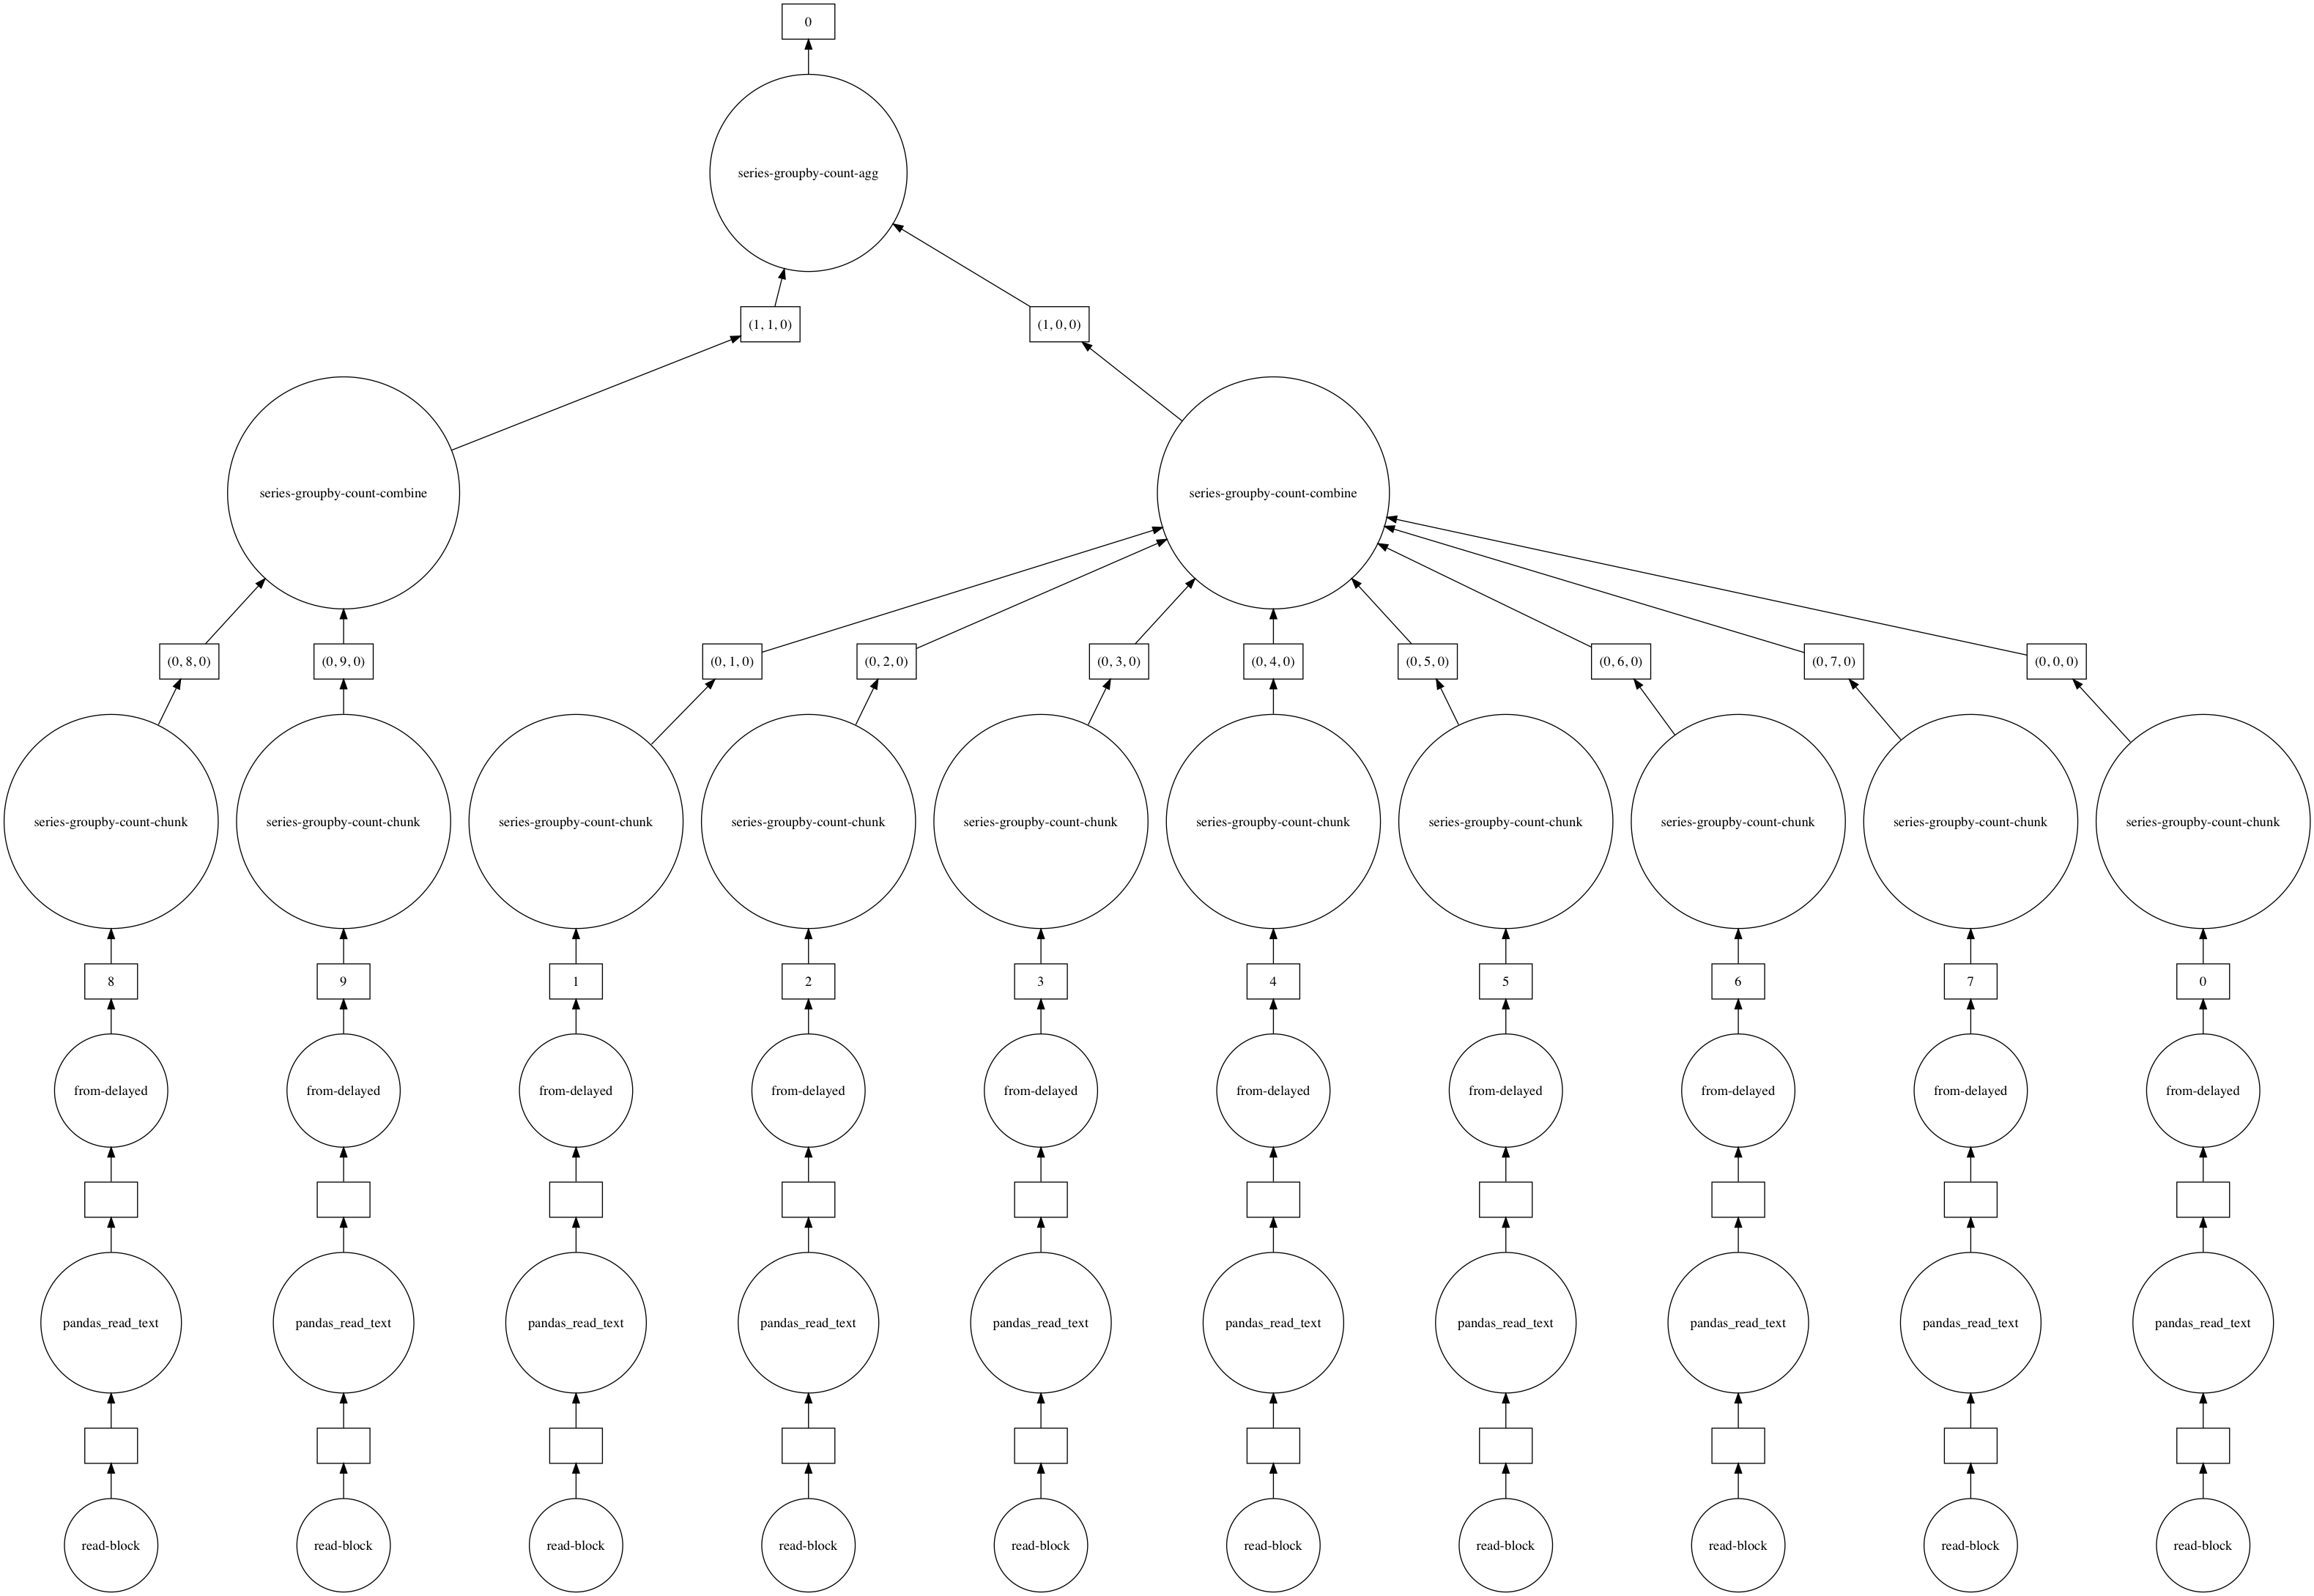

In [25]:
print('If we visualize this structure we\'ll see the picture of computation \n')
count_sites.visualize()

In [26]:
%%time
count_sites.compute().sort_values(ascending=False)[:20]

CPU times: user 196 ms, sys: 43.8 ms, total: 240 ms
Wall time: 177 ms


site
s.youtube.com                           8300
www.google.fr                           7813
www.google.com                          5441
mail.google.com                         4158
www.facebook.com                        4141
apis.google.com                         3758
r3---sn-gxo5uxg-jqbe.googlevideo.com    3244
r1---sn-gxo5uxg-jqbe.googlevideo.com    3094
plus.google.com                         2630
accounts.google.com                     2089
r2---sn-gxo5uxg-jqbe.googlevideo.com    1939
fr-mg42.mail.yahoo.com                  1868
www.youtube.com                         1804
r4---sn-gxo5uxg-jqbe.googlevideo.com    1702
clients1.google.com                     1493
download.jboss.org                      1441
s-static.ak.facebook.com                1388
static.ak.facebook.com                  1265
i1.ytimg.com                            1232
twitter.com                             1204
Name: site, dtype: int64

## JSON Files into Dask Bags

Dask Bag implements operations like map, filter, fold, and groupby on collections of Python objects. It does this in parallel with a small memory footprint using Python iterators. It is similar to a parallel version of PyToolz or a Pythonic version of the PySpark RDD.[Dask bag documentation](http://docs.dask.org/en/latest/bag-overview.html)


Dask bags are often used to parallelize simple computations on unstructured or semi-structured data like text data, log files, JSON records, or user defined Python objects.
 
Let's see example with our Medium data


In [27]:
import dask.bag as db
import json

In [28]:
print('Path to our medium data \n')
PATH = '../../data/kaggle_medium'
print(PATH)

Path to our medium data 

../../data/kaggle_medium


In [29]:
print('Wrap train json to dask bag format \n')
items = db.read_text(os.path.join(PATH,'train.json'))
items

Wrap train json to dask bag format 



dask.bag<bag-fro..., npartitions=1>

In [30]:
%%time
print('Let\'s look at one example \n')
print(items.take(1))

Let's look at one example 

('{"_id": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f", "_timestamp": 1520035195.282891, "_spider": "medium", "url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f", "domain": "medium.com", "published": {"$date": "2012-08-13T22:54:53.510Z"}, "title": "Medium Terms of Service \\u2013 Medium Policy \\u2013 Medium", "content": "<div><header class=\\"container u-maxWidth740\\"><div class=\\"uiScale uiScale-ui--regular uiScale-caption--regular postMetaHeader u-paddingBottom10 row\\"><div class=\\"col u-size12of12 js-postMetaLockup\\"><div class=\\"uiScale uiScale-ui--regular uiScale-caption--regular postMetaLockup postMetaLockup--authorWithBio u-flexCenter js-postMetaLockup\\"><div class=\\"u-flex0\\"><a class=\\"link u-baseColor--link avatar\\" href=\\"https://medium.com/@Medium?source=post_header_lockup\\" data-action=\\"show-user-card\\" data-action-source=\\"post_header_lockup\\" data-action-value=\\"504c7870fdb6\\" data-a

In [31]:
print('We can parse date with json library and get dict like object \n')
dict_items = items.map(json.loads)
print(type(dict_items))

We can parse date with json library and get dict like object 

<class 'dask.bag.core.Bag'>


In [32]:
dict_items.take(1)

({'_id': 'https://medium.com/policy/medium-terms-of-service-9db0094a1e0f',
  '_timestamp': 1520035195.282891,
  '_spider': 'medium',
  'url': 'https://medium.com/policy/medium-terms-of-service-9db0094a1e0f',
  'domain': 'medium.com',
  'published': {'$date': '2012-08-13T22:54:53.510Z'},
  'title': 'Medium Terms of Service – Medium Policy – Medium',
  'content': '<div><header class="container u-maxWidth740"><div class="uiScale uiScale-ui--regular uiScale-caption--regular postMetaHeader u-paddingBottom10 row"><div class="col u-size12of12 js-postMetaLockup"><div class="uiScale uiScale-ui--regular uiScale-caption--regular postMetaLockup postMetaLockup--authorWithBio u-flexCenter js-postMetaLockup"><div class="u-flex0"><a class="link u-baseColor--link avatar" href="https://medium.com/@Medium?source=post_header_lockup" data-action="show-user-card" data-action-source="post_header_lockup" data-action-value="504c7870fdb6" data-action-type="hover" data-user-id="504c7870fdb6" dir="auto"><div clas

In [33]:
print('We can take any key from all records \n')
title_bag  = dict_items.pluck('title')
print('With take method we received tuple of objects \n')
print(title_bag.take(3))

We can take any key from all records 

With take method we received tuple of objects 

('Medium Terms of Service – Medium Policy – Medium', 'Amendment to Medium Terms of Service Applicable to U.S. Government Users', '走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium')


We can write any function for processing data and apply it with map function

In [34]:
def clean_title(text):
    
    import string
    cut_set = set(string.punctuation)
    cut_set.update(['”','—','…', "“",'⌘','❤','+','®','➜','¬','–'])
    text = text.translate(text.maketrans(''.join(cut_set)," " * len(cut_set)))
    text = text.lower()
    return text

In [35]:
title_bag  = dict_items.pluck('title').map(clean_title)

In [36]:
title_bag.take(3)

('medium terms of service   medium policy   medium',
 'amendment to medium terms of service applicable to u s  government users',
 '走入山與海之間：閩東大刀會和兩岸走私   yun chen chien（簡韻真）   medium')

Process  meta_tags

In [37]:
meta_tags_bag  = dict_items.pluck('meta_tags')
test_meta = meta_tags_bag.take(3)

In [38]:
test_meta[1]

{'viewport': 'width=device-width, initial-scale=1',
 'title': 'Amendment to Medium Terms of Service Applicable to U.S. Government Users',
 'referrer': 'origin',
 'description': 'This agreement (“Amendment”) is an amendment to Medium’s Terms. It is between Medium and the U.S. Government and applies to the use of Medium Services by the Government. The reason for this Amendment…',
 'theme-color': '#000000',
 'og:title': 'Amendment to Medium Terms of Service Applicable to U.S. Government Users',
 'og:url': 'https://medium.com/policy/amendment-to-medium-terms-of-service-applicable-to-u-s-government-users-fccb00db67d7',
 'fb:app_id': '542599432471018',
 'og:description': 'This agreement (“Amendment”) is an amendment to Medium’s Terms. It is between Medium and the U.S. Government and applies to the use of…',
 'twitter:description': 'This agreement (“Amendment”) is an amendment to Medium’s Terms. It is between Medium and the U.S. Government and applies to the use of…',
 'author': 'Medium',
 'o

In [39]:
def clean_meta_tags(meta):
    author = meta['author'].strip()
    min_reads = int(meta['twitter:data1'].split()[0])
    return {'author':author, 'min_reads':min_reads}

In [40]:
meta_tags_bag= meta_tags_bag.map(clean_meta_tags)

In [41]:
meta_tags_bag.take(1)

({'author': 'Medium', 'min_reads': 5},)

### Combine all together

In [42]:
%%time
#content_bag = dict_items.pluck('content').map(clean_content)
title_bag  = dict_items.pluck('title').map(clean_title)
published_bag  = dict_items.pluck('published').map(lambda x: x['$date'])
meta_bag = dict_items.pluck('meta_tags').map(clean_meta_tags)
domain_bag = dict_items.pluck('domain')

CPU times: user 779 µs, sys: 248 µs, total: 1.03 ms
Wall time: 1.03 ms


In [43]:
@delayed
def combine_to_df(list_dict):
    
    list_df = [pd.DataFrame(dict_) for dict_ in list_dict]
    return pd.concat(list_df, axis=1)

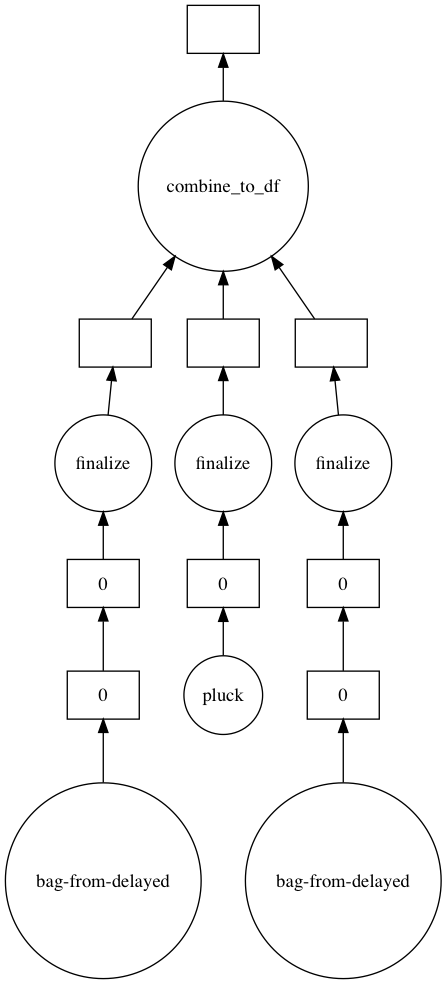

In [44]:
combined = combine_to_df([published_bag, meta_bag, domain_bag])
combined.visualize()

In [45]:
# It takes time, around a minute 
from dask.diagnostics import ProgressBar
with ProgressBar():
    df = combined.compute()
df.columns = ['published', 'Author','min_reads','domain']
df.head()

[########################################] | 100% Completed | 59.9s


,published,Author,min_reads,domain
0,2012-08-13T22:54:53.510Z,Medium,5,medium.com
1,2015-08-03T07:44:50.331Z,Medium,7,medium.com
2,2017-02-05T13:08:17.410Z,Yun-Chen Chien（簡韻真）,2,medium.com
3,2017-05-06T08:16:30.776Z,Vaibhav Khulbe,3,medium.com
4,2017-06-04T14:46:25.772Z,Vaibhav Khulbe,4,medium.com


In [46]:
print('We can create dask dataframe from pandas \n')
dd_no_content = dd.from_pandas(df, npartitions=4)

We can create dask dataframe from pandas 



In [47]:
dd_no_content

,published,Author,min_reads,domain
npartitions=4,,,,
0,object,object,int64,object
15579,...,...,...,...
31158,...,...,...,...
46737,...,...,...,...
62312,...,...,...,...


In [48]:
%%time
print('Transform published column to datetime as we did with pandas, it will by slightly slowly than in pandas \n')
df['published'] = pd.to_datetime(df.published, format='%Y-%m-%dT%H:%M:%S.%fZ')

Transform published column to datetime as we did with pandas, it will by slightly slowly than in pandas 

CPU times: user 277 ms, sys: 2.14 ms, total: 279 ms
Wall time: 277 ms


In [49]:
%%time
print('Transform published column to datetime  with pandas, \n')
dd_no_content['published'] = dd.to_datetime(dd_no_content.published, format='%Y-%m-%dT%H:%M:%S.%fZ').compute()

Transform published column to datetime  with pandas, 

CPU times: user 273 ms, sys: 6.49 ms, total: 279 ms
Wall time: 274 ms


In [50]:
dd_no_content.head()

,published,Author,min_reads,domain
0,2012-08-13 22:54:53.510,Medium,5,medium.com
1,2015-08-03 07:44:50.331,Medium,7,medium.com
2,2017-02-05 13:08:17.410,Yun-Chen Chien（簡韻真）,2,medium.com
3,2017-05-06 08:16:30.776,Vaibhav Khulbe,3,medium.com
4,2017-06-04 14:46:25.772,Vaibhav Khulbe,4,medium.com


In [51]:
print('We can apply function with mixed transformation to dask dataframe written for pandas df without changes \n')
def additional_time_features_df(df, to_cat_cols = ['Author','domain', 'month', 'year', 'day_of_week']):
    
    df['month'] = df['published'].apply(lambda ts: ts.month)
    df['year'] = df['published'].apply(lambda ts: ts.year)
    hour = df['published'].apply(lambda ts: ts.hour)
    df['hour'] = hour
    df['morning'] = ((hour >= 7) & (hour <= 11)).astype('float64')
    df['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
    df['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')
    df['night'] = ((hour >= 0) & (hour <= 6)).astype('int')
    df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
    df = df.drop(["hour"], axis=1)
    day_of_week = df['published'].dt.dayofweek.astype('int')
    df['day_of_week']=day_of_week
    df['weekend'] = (day_of_week >= 5).astype('int')
    # turn to categorical 
    df[to_cat_cols] = df[to_cat_cols].astype('category')
    
    return df

We can apply function with mixed transformation to dask dataframe written for pandas df without changes 



In [52]:
%%time
df_medium_train = additional_time_features_df(df.copy())

CPU times: user 694 ms, sys: 15.2 ms, total: 709 ms
Wall time: 707 ms


In [53]:
dd_medium_train = additional_time_features_df(dd_no_content)

In [54]:
%%time
dd_medium_train.compute()

CPU times: user 884 ms, sys: 52.9 ms, total: 937 ms
Wall time: 861 ms


,published,Author,min_reads,domain,month,year,morning,day,evening,night,sin_hour,cos_hour,day_of_week,weekend
0,2012-08-13 22:54:53.510,Medium,5,medium.com,8,2012,0.0,0,1,0,-5.000000e-01,8.660254e-01,0,0
1,2015-08-03 07:44:50.331,Medium,7,medium.com,8,2015,1.0,0,0,0,9.659258e-01,-2.588190e-01,0,0
2,2017-02-05 13:08:17.410,Yun-Chen Chien（簡韻真）,2,medium.com,2,2017,0.0,1,0,0,-2.588190e-01,-9.659258e-01,6,1
3,2017-05-06 08:16:30.776,Vaibhav Khulbe,3,medium.com,5,2017,1.0,0,0,0,8.660254e-01,-5.000000e-01,5,1
4,2017-06-04 14:46:25.772,Vaibhav Khulbe,4,medium.com,6,2017,0.0,1,0,0,-5.000000e-01,-8.660254e-01,6,1
5,2017-04-02 16:21:15.171,Kate Reed Petty,7,medium.com,4,2017,0.0,1,0,0,-8.660254e-01,-5.000000e-01,6,1
6,2016-08-15 04:16:02.103,exedre,12,medium.com,8,2016,0.0,0,0,1,8.660254e-01,5.000000e-01,0,0
7,2015-01-14 21:31:07.568,Raghav Haran,5,medium.com,1,2015,0.0,0,1,0,-7.071068e-01,7.071068e-01,2,0
8,2014-02-11 04:11:54.771,Francine Lee,4,medium.com,2,2014,0.0,0,0,1,8.660254e-01,5.000000e-01,1,0
9,2015-10-25 02:58:05.551,Raghav Haran,8,medium.com,10,2015,0.0,0,0,1,5.000000e-01,8.660254e-01,6,1


## Dask ML

Dask ML provides scalable machine learning algorithms in python which are compatible with scikit-learn. Let us first understand how scikit-learn handles the computations and then we will look at how Dask performs these operations differently. See dask-ml tutorials: [Examples from dask ml](http://ml.dask.org/examples.html)

You need to install dask-ml at first 

There are two main parts in dask ml:
    - approaches to handle big datasets 
    - approaches to handle big models

### Handle big model with dask distributed
The biggest model from our course was a random forest on text data in the week with Random Forest assignment. Below I just reproduce part of our assignment, but  I reduced nrows and max features in Count vectorizer, but you can check with original parameters

In [55]:
# Download data
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=5000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    3060
0    1940
Name: label, dtype: int64

In [56]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500, ngram_range=(1, 3))),
    ('clf', LogisticRegression(random_state=17))])

In [57]:
%%time
parameters = {'clf__C': (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, scoring ='roc_auc', cv=skf)
grid_search = grid_search.fit(X_text, y_text)

CPU times: user 8.34 s, sys: 139 ms, total: 8.47 s
Wall time: 8.47 s


In [58]:
grid_search.best_score_

0.7042233630808542

### Replace joblib with dask

In this approach all we need to do is replace joblib to dask distributed. We need to initialize distributed client, and change backend

In [59]:
%%time
from sklearn.externals import joblib
from dask.distributed import Client
client = Client()
parameters = {'clf__C': (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, scoring ='roc_auc', cv=skf)

t_start = time.time()

with joblib.parallel_backend('dask'):
    grid_search.fit(X_text, y_text)
t_end = time.time()
print('Elapsed time for grid_search with joblib replace (s):', round((t_end - t_start)))    

Elapsed time for grid_search with joblib replace (s): 5
CPU times: user 1.39 s, sys: 142 ms, total: 1.53 s
Wall time: 5.87 s


In [60]:
grid_search.best_score_

0.7042233630808542

### Replace Grid search with dask
Parallel to Gridsearch CV in sklearn, Dask provides a library called Dask-search CV (Dask-search CV is now included in Dask ML). It merges steps so that there are less repetitions. Below are the installation steps for Dask-search. We need to install it separately

In [61]:
#pip3 install dask-searchcv
import dask_searchcv as dcv

We can use a pipelines in dask grid search, and according the documentation we should use dask with pipelines with many opeations which could be parallelized, especially included feature union, but I've tried and get an error as a result... Anyway time consuming operations as CountVectorizer couldn't be parallelized, so here gridsearch from dask  only for classifier [documentation](https://dask-searchcv.readthedocs.io/en/latest/). 

In [62]:
%%time
vect = CountVectorizer(max_features=500, ngram_range=(1, 3))
Xvect = vect.fit_transform(X_text)

CPU times: user 762 ms, sys: 30.8 ms, total: 793 ms
Wall time: 788 ms


In [63]:
lr = LogisticRegression()
parameters = {'C': (0.1, 1, 10, 100)}
t_start = time.time()
grid_search = dcv.GridSearchCV(lr, parameters, scoring ='roc_auc', cv=skf)
grid_search.fit(Xvect, y_text)
t_end = time.time()
print(f'Elapsed time for grid_search (without time spended to vectorization) {round((t_end - t_start))} (s):')

Elapsed time for grid_search (without time spended to vectorization) 0 (s):


In [64]:
grid_search.best_score_

0.7020017187686919

I tried to see how good dask will be with random forest with original parameters, but sometimes this raise en error get "(OSError: [Errno 24] Too many open files) after execution, and I couldn't fix it...."  Sometimes it works ok, for small data it works in most cases, but if you re-run this notebook several times there is a big chance to get such an error. So, I believe that dask-ml very usefull, but for know I definitely don't know how it should be used properly. 

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=17)
min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

parameters = {'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}
grid_search = dcv.GridSearchCV(rf, parameters,  scoring ='roc_auc', cv=skf)
t_start = time.time()
grid_search.fit(Xvect, y_text)
t_end = time.time()
print(f'Elapsed time for dask grid_search for Random Forest {round((t_end - t_start))} (s):')

Elapsed time for dask grid_search for Random Forest 3 (s):


### Handle model with big data
There are number of models rewritten in dask, which could take dask object (huge arrays) and compute models on them. You could read more in dask documentation. Below an example with KMeans, but also there are dask version of linear models, processing functions. The notation is very similar to scikit-learn, and it should be easy to use. 

In [66]:
from dask_ml import datasets
from dask_ml.cluster import KMeans

In [67]:
X, y = datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
# Persist will give you back a lazy dask.delayed object 
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2)>

In [68]:
km = KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
    max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
    precompute_distances='auto', random_state=None, tol=0.0001)

Actually I read the article about dask couple of days ago and I've decided that task with tutorial a good way to get acquainted with the library. So I ask  you not to be very strict if  I misunderstood something:))